# Bloom Shift: Climate Change and Flowering Patterns of California's Native and Invasive Forbs

Author: Ian Morris-Sibaja

##  About 

![Sedgewick Reserve](images/Sedgwick.jpg)

Image credits: [UCNRS](hhttps://sedgwick.nrs.ucsb.edu/media/photo-gallery/)

### Purpose

This study investigates how climate change influences the flowering phenology of native and invasive Californian annual forbs. Given California's status as a biodiversity hotspot and the region's susceptibility to hotter and drier conditions, this research aims to understand how shifts in temperature and precipitation affect plant communities. Specifically, we address two primary questions:

1) Does the average flowering observation date correlate with changes in annual temperature or precipitation?
2) Are particular climate zones, such as coastal Southern California, experiencing more pronounced phenological shifts compared to the state as a whole?

By analyzing 50 years of data on nine plant species and correlating it with climate trends, this research seeks to highlight the potential impacts of climate change on native and invasive species, with implications for ecosystem stability and conservation planning.

### Highlights and Objectives

- Phenological Shifts: Investigate if flowering times correlate with changes in temperature and precipitation over time.
- Spatial Analysis: Determine if shifts are more pronounced in certain climate zones, e.g., coastal Southern California.
- Conservation Implications: Understand how these changes impact the ecosystem dynamics and inform conservation strategies for native biodiversity.
- Focused on California, a biodiversity hotspot particularly sensitive to climate changes.
- Identified trends for each species using statistical models (OLS regression) to link phenology with climate trends.
- Highlights differences between native and invasive species in their response to environmental changes.

### About the data

The study relies on 50 years of data (1966–2016) on flowering observations for nine Californian annual forb species, including both native and invasive types. This dataset integrates:

- Flowering data: Derived from occurrence records supplied, focusing on observations from California.
- Climate data: Compiled from the National Weather Service Cooperative Observer Program (NWS COOP), including annual temperature and precipitation records.
- Spatial data: Uses shapefiles from NOAA to map flowering data to specific climate divisions in California.
- Data preprocessing ensured temporal consistency and excluded irrelevant records.

## Import Libraries

In [1]:
#| code-fold: true
#| code-summary: "Import Modules"
# Import modules
import pandas as pd
import os
from plotly import express as px
import plotly.graph_objects as go
import numpy as np
import geopandas as gpd
from plotly.offline import iplot
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
import seaborn as sb
import statsmodels.formula.api as smf
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

## Climate Data

In [2]:
#| code-fold: true
#| code-summary: "Load Climate Data"

# set the directory to the climate data
directory = './data/climate/'

# create a dictionary to store all files in this directory
d = {}
# iterate over files in this directory, add each name of file and its contents into a dictionary
for filename in os.listdir(directory):
        d[filename] = pd.read_csv(f'./data/climate/{filename}', encoding= 'unicode_escape')
del d['.DS_Store']

In [3]:
# iterate over the dictionary and add the COOP_ID and type of data to each dataframe
maxMinT = []
maxMinP = []

for key, value in d.items():
    if key[7:8] == 'p':
        maxMinP.append(d[key]['YEAR(S)'].min())
    else:
        maxMinT.append(d[key]['YEAR(S)'].min())
    value['COOP_ID'] = key[1:6]
    value['type'] = key[7:8]
    d[key] = d[key].loc[:, ~d[key].columns.str.contains('^Unnamed')]

The National Weather Service (NWS) Cooperative Observer Program (COOP) is a network of daily weather observations taken by more than 8,500 volunteers. Here we import and clean the data to be manipulated in out dataset.

In [4]:
# Create a dataframe with COOP information 
coopNames = pd.read_csv('./data/Coopnames.csv')
coopNames = coopNames.drop([0,1,2]).reset_index(drop=True)
coopNames = coopNames[['COOP_ID', 'COOP_NAME', 'DIV', 'LATITUDE', 'LONGITUDE']]

# convert COOP_ID to int
coopNames.COOP_ID = coopNames.COOP_ID.astype(int)

In [5]:
# merge the COOP information with the climate data
coop = pd.concat(d.values(), ignore_index=True)

# filter the data to only include years 1966-2016
coop = coop[coop['YEAR(S)']>=1966]
coop = coop[coop['YEAR(S)']<=2016]

# drop rows with irrelevant data
coop = coop.replace(['-----'], np.nan).reset_index(drop=True)
coop = coop.loc[:, ~coop.columns.str.contains('^Unnamed')]
coop = coop.drop(['January'], axis =1)

In [6]:
#| code-fold: true
#| code-summary: "COOP Data"
coop

,YEAR(S),JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN,COOP_ID,type
0,1966,38.29,42.33,48.13,57.52,64.40,64.77,70.23,75.16,67.30,58.00,47.87,42.13,57.64,40738,t
1,1967,39.70,45.12,45.50,44.10,60.74,68.47,75.90,77.66,71.48,57.37,51.82,34.60,70.18,40738,t
2,1968,37.07,47.96,48.62,NaN,58.58,67.92,75.92,70.52,68.95,57.45,44.73,37.63,60.21,40738,t
3,1969,36.94,40.71,46.44,52.65,64.53,68.70,74.35,72.60,69.97,54.28,48.15,43.06,57.21,40738,t
4,1970,42.75,47.15,49.00,48.63,61.53,70.80,76.71,74.50,65.97,56.77,47.27,36.48,59.85,40738,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5929,2012,0.62,0.45,1.73,1.39,0.03,0.00,0.00,0.00,0.00,0.28,0.49,1.90,4.09,43747,p
5930,2013,0.22,0.48,0.79,0.08,0.17,0.00,0.00,0.00,0.01,0.00,0.33,0.16,2.24,43747,p
5931,2014,0.30,1.38,0.27,0.35,0.00,0.00,0.00,0.00,0.03,0.00,0.94,2.52,5.79,43747,p
5932,2015,0.08,0.72,0.02,0.77,0.10,0.00,0.45,0.00,0.00,0.38,0.91,1.40,4.83,43747,p


In [7]:
# assign the correct data types to the columns
coop = coop.astype({col: float for col in coop.columns[1:-2]})
coop = coop.astype({col: int for col in coop.columns[:1]})
coop = coop.astype({col: int for col in coop.columns[-2:-1]})

In [8]:
# merge the COOP names with COOP data
coop = coop.merge(coopNames, left_on='COOP_ID', right_on='COOP_ID')

In [9]:
# assign percipitation and temperature data to separate dataframes
coopT = coop[coop['type'] == 't']
coopP = coop[coop['type'] == 'p']

In [10]:
coopT.head()

,YEAR(S),JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN,COOP_ID,type,COOP_NAME,DIV,LATITUDE,LONGITUDE
0,1966,38.29,42.33,48.13,57.52,64.40,64.77,70.23,75.16,67.30,58.00,47.87,42.13,57.64,40738,t,BIG BAR 4,1,40 44 27,-123 12 33
1,1967,39.70,45.12,45.50,44.10,60.74,68.47,75.90,77.66,71.48,57.37,51.82,34.60,70.18,40738,t,BIG BAR 4,1,40 44 27,-123 12 33
2,1968,37.07,47.96,48.62,NaN,58.58,67.92,75.92,70.52,68.95,57.45,44.73,37.63,60.21,40738,t,BIG BAR 4,1,40 44 27,-123 12 33
3,1969,36.94,40.71,46.44,52.65,64.53,68.70,74.35,72.60,69.97,54.28,48.15,43.06,57.21,40738,t,BIG BAR 4,1,40 44 27,-123 12 33
4,1970,42.75,47.15,49.00,48.63,61.53,70.80,76.71,74.50,65.97,56.77,47.27,36.48,59.85,40738,t,BIG BAR 4,1,40 44 27,-123 12 33


In [11]:
coopP.head()

,YEAR(S),JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN,COOP_ID,type,COOP_NAME,DIV,LATITUDE,LONGITUDE
102,1966,1.35,1.40,1.16,0.05,0.07,0.22,0.39,0.19,0.20,0.46,0.83,NaN,6.32,41424,p,CAMPO,6,32 37 24,-116 28 22
103,1967,1.42,0.00,1.03,3.54,0.48,0.06,0.34,0.49,0.82,0.00,3.65,4.23,16.06,41424,p,CAMPO,6,32 37 24,-116 28 22
104,1968,0.58,0.73,2.19,0.85,0.28,0.03,1.88,0.06,0.00,0.05,0.72,1.66,9.03,41424,p,CAMPO,6,32 37 24,-116 28 22
105,1969,8.30,5.67,1.96,0.10,0.43,0.12,0.01,0.00,0.20,0.02,1.85,0.26,18.92,41424,p,CAMPO,6,32 37 24,-116 28 22
106,1970,0.85,0.96,3.95,1.18,0.00,0.03,0.03,2.66,0.08,0.12,1.28,2.66,13.80,41424,p,CAMPO,6,32 37 24,-116 28 22


In [12]:
# drop the type column from the dataframes
coopP = coopP.drop(['type'], axis =1).reset_index(drop = True)
coopT = coopT.drop(['type'], axis =1).reset_index(drop = True)

In [13]:
coopT.head()

,YEAR(S),JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN,COOP_ID,COOP_NAME,DIV,LATITUDE,LONGITUDE
0,1966,38.29,42.33,48.13,57.52,64.40,64.77,70.23,75.16,67.30,58.00,47.87,42.13,57.64,40738,BIG BAR 4,1,40 44 27,-123 12 33
1,1967,39.70,45.12,45.50,44.10,60.74,68.47,75.90,77.66,71.48,57.37,51.82,34.60,70.18,40738,BIG BAR 4,1,40 44 27,-123 12 33
2,1968,37.07,47.96,48.62,NaN,58.58,67.92,75.92,70.52,68.95,57.45,44.73,37.63,60.21,40738,BIG BAR 4,1,40 44 27,-123 12 33
3,1969,36.94,40.71,46.44,52.65,64.53,68.70,74.35,72.60,69.97,54.28,48.15,43.06,57.21,40738,BIG BAR 4,1,40 44 27,-123 12 33
4,1970,42.75,47.15,49.00,48.63,61.53,70.80,76.71,74.50,65.97,56.77,47.27,36.48,59.85,40738,BIG BAR 4,1,40 44 27,-123 12 33


In [14]:
coopP.head()

,YEAR(S),JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ANN,COOP_ID,COOP_NAME,DIV,LATITUDE,LONGITUDE
0,1966,1.35,1.40,1.16,0.05,0.07,0.22,0.39,0.19,0.20,0.46,0.83,NaN,6.32,41424,CAMPO,6,32 37 24,-116 28 22
1,1967,1.42,0.00,1.03,3.54,0.48,0.06,0.34,0.49,0.82,0.00,3.65,4.23,16.06,41424,CAMPO,6,32 37 24,-116 28 22
2,1968,0.58,0.73,2.19,0.85,0.28,0.03,1.88,0.06,0.00,0.05,0.72,1.66,9.03,41424,CAMPO,6,32 37 24,-116 28 22
3,1969,8.30,5.67,1.96,0.10,0.43,0.12,0.01,0.00,0.20,0.02,1.85,0.26,18.92,41424,CAMPO,6,32 37 24,-116 28 22
4,1970,0.85,0.96,3.95,1.18,0.00,0.03,0.03,2.66,0.08,0.12,1.28,2.66,13.80,41424,CAMPO,6,32 37 24,-116 28 22


In [15]:
# group the data by year and calculate the average temperature and precipitation
coopTavg = coopT.groupby(['YEAR(S)'])[['ANN']].mean()
coopPavg = coopP.groupby(['YEAR(S)'])[['ANN']].mean()

In [16]:
coopPavg.head()

,ANN
YEAR(S),
1966,13.723684
1967,18.576316
1968,13.371930
1969,24.774386
1970,19.625789


In [17]:

coopTavg.head()

,ANN
YEAR(S),
1966,59.034815
1967,58.699091
1968,58.755893
1969,58.758750
1970,59.136316


## Flowering Data
The `flowerDataFrame` function processes and filters occurrence data for a specified plant species in California, returning a clean, structured DataFrame with relevant details such as geographic coordinates, flowering dates, and native status.

In [18]:
#| code-fold: true
#| code-summary: "Flowering Data Function"

def flowerDataFrame(name, isNative):
    '''
    Returns a dataframe of the species data for a specific species in California

    @param name: a string of the name of the species that you want to obtain data for
    @param isNative: a string stating whether the species is native to california or not
    '''
    # Load csv of the species data into a pandas dataframe
    df = pd.read_csv(f"./data/{name}/occurrence.txt", sep='\t', low_memory=False)
    #take only specific columns from the bigger dataframe
    df = df[['scientificName', 'decimalLongitude', 'decimalLatitude', 'day', 'month', 'year', 'stateProvince', 'countryCode']]

    #add a column stating if it is native or not
    df['native'] = isNative

    #make new column that will drop any unnecessary abbreviations at the end of each name of observation
    df['species'] = df['scientificName'].str[:len(name)]
    #make sure dataframe only includes desired species
    df = df[df['species'] == name]
    #drop now unused column
    df = df.drop(['scientificName'], axis=1)

    #make sure dataframe only includes observations from Califronia
    df = df[(df['countryCode'] == "US")]
    df = df[(df['stateProvince'] == "California") | (df['stateProvince'] == "Ca")]
    df = df[df['decimalLongitude'] > -125]
    df = df[df['decimalLongitude'] < -113]
    #drop because we know all measurements in entire dataset are in california
    df = df.drop(['stateProvince'], axis=1)
    df = df.drop(['countryCode'], axis=1)
    df = df.dropna()
    df = df.reset_index(drop=True)
    
    #add column called day of year
    df[list(["day", "month", "year"])] = df[list(["day", "month", "year"])].astype(int)
    df[list(["day", "month", "year"])] = df[list(["day", "month", "year"])].astype(str)
    
    df['month'] = df['month'].apply(lambda x: '{0:0>2}'.format(x))
    df['day'] = df['day'].apply(lambda x: '{0:0>2}'.format(x))
    
    df["DOY"] = df["year"].copy()
    month = df["month"].copy()
    day = df["day"].copy()
    
    df["DOY"] = df["DOY"].str.cat((month, day), sep ="-")
    df['DOY'] = pd.to_datetime(df['DOY'], format='%Y-%m-%d')
    df['DOY'] = df['DOY'].dt.dayofyear

    #convert months and years into ints instead of floats 
    df[list(["year"])] = df[list(["year"])].astype(int)
    
    #make sure occurances are of from 1920-2020
    df = df[df['year'] > 1919]
    df = df[df['year'] < 2021]
    df = df.reset_index(drop = True)
    
    #give columns more readable names
    df = df.rename(columns={'decimalLongitude': 'longitude',
                            'decimalLatitude':  'latitude'})
    #keep latitude rounding same as eventual climate data
    df.longitude = df.longitude.round(3)
    df.latitude = df.latitude.round(3)

    
    return df

In [19]:
#native plants
lasCal = flowerDataFrame('Lasthenia californica', 'yes')
plntgo = flowerDataFrame("Plantago erecta Morris", 'yes')
clrkiP = flowerDataFrame("Clarkia purpurea", 'yes')
clrkiB = flowerDataFrame("Clarkia bottae", 'yes')
chaenc = flowerDataFrame("Chaenactis glabriuscula", 'yes')
amsink = flowerDataFrame("Amsinckia menziesii", 'yes')

#non-native
mdcgoP = flowerDataFrame("Medicago polymorpha", 'no')
cntrea = flowerDataFrame("Centaurea solstitialis", 'no')
brssTG = flowerDataFrame("Brassica tournefortii Gouan", 'no')

In [20]:
#concat all species dataframes into one big one
flowersCA = pd.concat([lasCal, plntgo, clrkiP, clrkiB, chaenc, amsink,
                       mdcgoP, cntrea, brssTG])
#convert into geodataframe to be easily compared wihtin shape files in the future
flowersCA = gpd.GeoDataFrame(flowersCA, geometry=gpd.points_from_xy(flowersCA.longitude, flowersCA.latitude))

## Climate Division Wrangling
Below I take a shape file from from NOAAs database, and determine which climate divisions each observation falls under.

In [21]:
# from NOAAs shapefile, find useful columns and determine which are within CA
climateDivs = gpd.read_file("./data/climateDiv/GIS.OFFICIAL_CLIM_DIVISIONS.shp")
climateDivs = climateDivs[climateDivs["ST_ABBRV"] == 'CA']
climateDivs = climateDivs[["CD_NEW", 'geometry']]

In [22]:
# set both coordinate reference systems to be the same so the dataframes are accurately compared
climateDivs = climateDivs.set_crs("EPSG:4326", allow_override=True)
flowersCA = flowersCA.set_crs("EPSG:4326")

In [23]:
# this will join the two datasets based on if flowering observation
# geometry points are within the climate division shapefiles, 
# and add a column within each observation of said Climate Divsion
flowersCA = gpd.sjoin(flowersCA, climateDivs, how='inner', predicate='within')
flowersCA = flowersCA.drop(['index_right'], axis = 1)
flowersCA = flowersCA.reset_index(drop = True)
flowersCA = flowersCA.rename(columns={'CD_NEW' : 'ClimateDivision'})
flowersCA = flowersCA[flowersCA['year']>=1966]
flowersCA = flowersCA[flowersCA['year']<=2016]
# write only necessary info to csv for quick web parsing
flowersCA.to_csv('./data/flowersCA.csv')


In [24]:
# group the data by species, year, native status, and climate division, and calculate the average day of year that the species flowers
avgPhenologyDiv = flowersCA.groupby(['species', 'year', 'native', 'ClimateDivision'])[["DOY"]].mean().reset_index().round(0)
avgPhenologyDiv

,species,year,native,ClimateDivision,DOY
0,Amsinckia menziesii,1966,yes,4,119.0
1,Amsinckia menziesii,1966,yes,5,90.0
2,Amsinckia menziesii,1966,yes,6,114.0
3,Amsinckia menziesii,1967,yes,4,125.0
4,Amsinckia menziesii,1967,yes,5,93.0
...,...,...,...,...,...
1497,Plantago erecta Morris,2016,yes,1,115.0
1498,Plantago erecta Morris,2016,yes,2,99.0
1499,Plantago erecta Morris,2016,yes,4,87.0
1500,Plantago erecta Morris,2016,yes,5,80.0


## Statistical Analysis

Now I will employ linear regression models to evaluate the relationship between flowering phenology and climate variables (temperature and precipitation), identifying significant correlations and trends across species, regions, and time. My code calculates statistics of the state, Southern California itself, and climate division 6 to view the relationship between flowering phenology and climate variables (temperature and precipitation) using linear regression:

- Data Preparation: For each species, the average annual temperature, precipitation, and flowering day-of-year (DOY) are grouped by year and filtered to ensure overlapping years.
- Regression Analysis: Linear regression models are applied separately to assess the relationship between DOY and temperature, as well as DOY and precipitation.
- Results Compilation: The species name, p-values, R-squared, and adjusted R-squared values for both models are stored in a summary DataFrame (stateSum).
- Significant Results: If the regression p-values indicate statistical significance, the corresponding data for temperature or precipitation is labeled, augmented with species and region information, and added to a significant results DataFrame (sigSum).

In [25]:
# create a dictionary to store unique species names
flowD = {}
for i in range(len(avgPhenologyDiv.species.unique())):
    flowD[i] = avgPhenologyDiv.species.unique()[i]

In [26]:
# create a dictionary to store species with significant p-values
sigSum = pd.DataFrame([])

# set significance level
pval = .05

In [27]:
#| code-fold: true
#| warning: false
#| code-summary: "State Wide Summary Data"

# create a dictionary to store the state summary data
dstate = {}
# iterate over the unique species and calculate the linear regression for each species
stateSum = pd.DataFrame([])
for i in range(len(flowD)):
    
    # filter the data to only include the species of interest
    avgF = avgPhenologyDiv[avgPhenologyDiv['species'] == flowD[i]]
    
    # group the data by year and calculate the average temperature and precipitation
    xT = coopT.groupby(['YEAR(S)'])[['ANN']].mean().reset_index()
    xP = coopP.groupby(['YEAR(S)'])[['ANN']].mean().reset_index()
    
    # group the data by year and calculate the average day of year that the species flowers
    y = avgF.groupby(['year'])[['DOY']].mean().reset_index()

    # create a list of years that are in the temperature and precipitation data 
    xTy = list(xT['YEAR(S)'])
    xPy = list(xP['YEAR(S)'])
    
    # create a list of years that are in the flowering data 
    yy = list(y.year)

    # iterate over the years in the temperature and precipitation data and remove any years that are not in the flowering data
    for j in xTy:
        if j not in yy:
            xT = xT[xT['YEAR(S)'] != j]
    for k in xPy:
        if k not in yy:
            xP = xP[xP['YEAR(S)'] != k]

    # reset the index of the temperature, precipitation, and flowering data
    xT = xT[['ANN']].reset_index(drop=True)
    xP = xP[['ANN']].reset_index(drop=True)
    y = y[['DOY']].reset_index(drop=True)

    # merge the temperature, precipitation, and flowering data
    dfT = xT.join(y)
    dfP = xP.join(y)
    
    # sort the data by the average temperature and precipitation
    dfT = dfT.sort_values(by=['ANN'])
    dfP = dfP.sort_values(by=['ANN'])

    # assign the species name to the state summary dataframe
    stateSum.loc[i, "Species"] = flowD[i]

    # calculate the linear regression for temperature and precipitation
    resultsT = smf.ols('DOY ~ ANN', data=dfT).fit()
    resultsP = smf.ols('DOY ~ ANN', data=dfP).fit()
    
    # assign the p-values, r-squared, and adjusted r-squared to the state summary dataframe
    stateSum.loc[i,'Temp P-Value'] = resultsT.summary2().tables[1]['P>|t|'][1]
    stateSum.loc[i,'Temp R-Squared'] = resultsT.summary2().tables[0][1][6]
    stateSum.loc[i,'Temp Adj. R-Squared'] = resultsT.summary2().tables[0][3][0]
    
    stateSum.loc[i,'Precip P-Value'] = resultsP.summary2().tables[1]['P>|t|'][1]
    stateSum.loc[i,'Precip R-Squared'] = resultsP.summary2().tables[0][1][6]
    stateSum.loc[i,'Precip Adj. R-Squared'] = resultsP.summary2().tables[0][3][0]
    
    # assign the species name to the significant summary dataframe if the p-value is less than the significance level
    if (resultsT.summary2().tables[1]['P>|t|'][1]<= pval):
        dfT['Type'] = 'T'
        dfT['Species'] = f'{flowD[i]}'
        dfT['Region'] = 'State'
        sigSum = pd.concat([sigSum, dfT], ignore_index=True)
    if (resultsP.summary2().tables[1]['P>|t|'][1]<= pval):
        dfP['Type'] = 'P'
        dfP['Species'] = f'{flowD[i]}'
        dfP['Region'] = 'State'
        sigSum = pd.concat([sigSum, dfP], ignore_index=True)

/var/folders/bb/wb3979614rq024pwwnbz2sc40000gn/T/ipykernel_37025/3566967394.py:57: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/bb/wb3979614rq024pwwnbz2sc40000gn/T/ipykernel_37025/3566967394.py:61: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/bb/wb3979614rq024pwwnbz2sc40000gn/T/ipykernel_37025/3566967394.py:66: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/bb/wb3979614rq024pwwnbz2sc40000gn/T/

In [28]:
stateSum

,Species,Temp P-Value,Temp R-Squared,Temp Adj. R-Squared,Precip P-Value,Precip R-Squared,Precip Adj. R-Squared
0,Amsinckia menziesii,0.045038,0.084,0.065,0.530467,0.009,-0.013
1,Brassica tournefortii Gouan,0.656550,0.005,-0.018,0.230165,0.033,0.011
2,Centaurea solstitialis,0.663545,0.004,-0.017,0.447359,0.012,-0.009
3,Chaenactis glabriuscula,0.022766,0.101,0.083,0.966052,0.000,-0.020
4,Clarkia bottae,0.047639,0.084,0.064,0.084706,0.065,0.044
5,Clarkia purpurea,0.030003,0.093,0.074,0.096125,0.055,0.036
6,Lasthenia californica,0.226127,0.030,0.010,0.116397,0.050,0.030
7,Medicago polymorpha,0.738173,0.002,-0.018,0.261980,0.026,0.006
8,Plantago erecta Morris,0.097705,0.055,0.036,0.765565,0.002,-0.019


In [29]:
#| code-fold: true
#| warning: false
#| code-summary: "Socal Summary Data"

# create a dictionary to store the south state summary data
souSum = pd.DataFrame([])

# iterate over the unique species and calculate the linear regression for each species
for i in range(len(flowD)):
    # filter the data to only include the species of interest in climate divisions 6-9
    avgF = avgPhenologyDiv[avgPhenologyDiv['ClimateDivision'] >= 6] 
    avgF = avgF[avgF['species'] == flowD[i]]    
    
    # group the data by year and calculate the average temperature and precipitation
    xT = coopT.groupby(['YEAR(S)'])[['ANN']].mean().reset_index()
    xP = coopP.groupby(['YEAR(S)'])[['ANN']].mean().reset_index()
    
    # group the data by year and calculate the average day of year that the species flowers
    y = avgF.groupby(['year'])[['DOY']].mean().reset_index()

    # create a list of years that are in the temperature and precipitation data
    xTy = list(xT['YEAR(S)']) 
    xPy = list(xP['YEAR(S)']) 
    # create a list of years that are in the flowering data
    yy = list(y.year)

    # iterate over the years in the temperature and precipitation data and remove any years that are not in the flowering data
    for j in xTy:
        if j not in yy:
            xT = xT[xT['YEAR(S)'] != j]
    
    for k in xPy:
        if k not in yy:
            xP = xP[xP['YEAR(S)'] != k]

    # reset the index of the temperature, precipitation, and flowering data
    xT = xT[['ANN']].reset_index(drop=True)
    xP = xP[['ANN']].reset_index(drop=True)
    y = y[['DOY']].reset_index(drop=True)

    # merge the temperature, precipitation, and flowering data
    dfT = xT.join(y)
    dfP = xP.join(y)
    
    # sort the data by the average temperature and precipitation
    dfT = dfT.sort_values(by=['ANN'])
    dfP = dfP.sort_values(by=['ANN'])

    # assign the species name to the south summary dataframe
    souSum.loc[i, "Species"] = flowD[i]

    # calculate the linear regression for temperature and precipitation
    resultsT = smf.ols('DOY ~ ANN', data=dfT).fit()
    resultsP = smf.ols('DOY ~ ANN', data=dfP).fit()
    
    # assign the p-values, r-squared, and adjusted r-squared to the south summary dataframe
    souSum.loc[i,'Temp P-Value'] = resultsT.summary2().tables[1]['P>|t|'][1]
    souSum.loc[i,'Temp R-Squared'] = resultsT.summary2().tables[0][1][6]
    souSum.loc[i,'Temp Adj. R-Squared'] = resultsT.summary2().tables[0][3][0]
    
    souSum.loc[i,'Precip P-Value'] = resultsP.summary2().tables[1]['P>|t|'][1]
    souSum.loc[i,'Precip R-Squared'] = resultsP.summary2().tables[0][1][6]
    souSum.loc[i,'Precip Adj. R-Squared'] = resultsP.summary2().tables[0][3][0]
    
    # assign the species name to the significant summary dataframe if the p-value is less than the significance level
    if (resultsT.summary2().tables[1]['P>|t|'][1]<= pval):
        dfT['Type'] = 'T'
        dfT['Species'] = f'{flowD[i]}'
        dfT['Region'] = 'South'
        sigSum = pd.concat([sigSum, dfT], ignore_index=True)
        sigSum = pd.concat(dfT)
        
    if (resultsP.summary2().tables[1]['P>|t|'][1]<= pval):
        dfP['Type'] = 'P'
        dfP['Species'] = f'{flowD[i]}'
        dfP['Region'] = 'South'
        sigSum = pd.concat([sigSum, dfP], ignore_index=True)

/var/folders/bb/wb3979614rq024pwwnbz2sc40000gn/T/ipykernel_37025/1416643667.py:57: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/bb/wb3979614rq024pwwnbz2sc40000gn/T/ipykernel_37025/1416643667.py:61: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/bb/wb3979614rq024pwwnbz2sc40000gn/T/ipykernel_37025/1416643667.py:66: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/bb/wb3979614rq024pwwnbz2sc40000gn/T/

In [30]:
souSum

,Species,Temp P-Value,Temp R-Squared,Temp Adj. R-Squared,Precip P-Value,Precip R-Squared,Precip Adj. R-Squared
0,Amsinckia menziesii,0.875755,0.001,-0.022,0.875616,0.001,-0.022
1,Brassica tournefortii Gouan,0.904122,0.000,-0.022,0.404617,0.016,-0.007
2,Centaurea solstitialis,0.702031,0.004,-0.024,0.440332,0.017,-0.011
3,Chaenactis glabriuscula,0.115176,0.050,0.030,0.594184,0.006,-0.014
4,Clarkia bottae,0.270753,0.029,0.006,0.728577,0.003,-0.021
5,Clarkia purpurea,0.336247,0.019,-0.001,0.203625,0.033,0.013
6,Lasthenia californica,0.263063,0.027,0.006,0.752329,0.002,-0.020
7,Medicago polymorpha,0.199275,0.035,0.014,0.897705,0.000,-0.021
8,Plantago erecta Morris,0.336801,0.020,-0.001,0.425241,0.014,-0.007


In [31]:
#| code-fold: true
#| warning: false
#| code-summary: "Climate Division 6 Summary Data"

# create a dictionary to store the average flowering days
flowD = {}

# iterate over the unique species and average flowering days
for i in range(len(avgPhenologyDiv.species.unique())):
    flowD[i] = avgPhenologyDiv.species.unique()[i]
    
# create a dataframe to store the significant summary data for climate divisions 6
sixSum = pd.DataFrame([])

# iterate over the unique species and calculate the linear regression for each species
for i in range(len(flowD)):
    # filter the data to only include the species of interest in climate division 6
    avgF = avgPhenologyDiv[avgPhenologyDiv['ClimateDivision'] == 6] 
    avgF = avgF[avgF['species'] == flowD[i]]    
    
    # group the data by year and calculate the average temperature and precipitation
    xT = coopT.groupby(['YEAR(S)'])[['ANN']].mean().reset_index()
    xP = coopP.groupby(['YEAR(S)'])[['ANN']].mean().reset_index()
    
    # group the data by year and calculate the average day of year that the species flowers
    y = avgF.groupby(['year'])[['DOY']].mean().reset_index()

    # create a list of years that are in the temperature and precipitation data
    xTy = list(xT['YEAR(S)']) 
    xPy = list(xP['YEAR(S)']) 
    yy = list(y.year)

    # iterate over the years in the temperature and precipitation data and remove any years that are not in the flowering data
    for j in xTy:
        if j not in yy:
            xT = xT[xT['YEAR(S)'] != j]
    
    for k in xPy:
        if k not in yy:
            xP = xP[xP['YEAR(S)'] != k]

    # reset the index of the temperature, precipitation, and flowering data
    xT = xT[['ANN']].reset_index(drop=True)
    xP = xP[['ANN']].reset_index(drop=True)
    y = y[['DOY']].reset_index(drop=True)

    # merge the temperature, precipitation, and flowering data
    dfT = xT.join(y)
    dfP = xP.join(y)
    
    # sort the data by the average temperature and precipitation
    dfT = dfT.sort_values(by=['ANN'])
    dfP = dfP.sort_values(by=['ANN'])

    # assign the species name to the six summary dataframe
    sixSum.loc[i, "Species"] = flowD[i]

    # calculate the linear regression for temperature and precipitation
    resultsT = smf.ols('DOY ~ ANN', data=dfT).fit()
    resultsP = smf.ols('DOY ~ ANN', data=dfP).fit()
    
    # assign the p-values, r-squared, and adjusted r-squared to the six summary dataframe
    sixSum.loc[i,'Temp P-Value'] = resultsT.summary2().tables[1]['P>|t|'][1]
    sixSum.loc[i,'Temp R-Squared'] = resultsT.summary2().tables[0][1][6]
    sixSum.loc[i,'Temp Adj. R-Squared'] = resultsT.summary2().tables[0][3][0]

    sixSum.loc[i,'Precip P-Value'] = resultsP.summary2().tables[1]['P>|t|'][1]
    sixSum.loc[i,'Precip R-Squared'] = resultsP.summary2().tables[0][1][6]
    sixSum.loc[i,'Precip Adj. R-Squared'] = resultsP.summary2().tables[0][3][0]
    
    # assign the species name to the significant summary dataframe if the p-value is less than the significance level
    if (resultsT.summary2().tables[1]['P>|t|'][1]<= pval):
        dfT['Type'] = 'T'
        dfT['Species'] = f'{flowD[i]}'
        dfT['Region'] = 'Six'
        sigSum = pd.concat([sigSum, dfT], ignore_index=True)
    if (resultsP.summary2().tables[1]['P>|t|'][1]<= pval):
        dfP['Type'] = 'P'
        dfP['Species'] = f'{flowD[i]}'
        dfP['Region'] = 'Six'
        sigSum = pd.concat([sigSum, dfP], ignore_index=True)

/var/folders/bb/wb3979614rq024pwwnbz2sc40000gn/T/ipykernel_37025/2246876704.py:63: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/bb/wb3979614rq024pwwnbz2sc40000gn/T/ipykernel_37025/2246876704.py:67: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/bb/wb3979614rq024pwwnbz2sc40000gn/T/ipykernel_37025/2246876704.py:72: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/bb/wb3979614rq024pwwnbz2sc40000gn/T/

In [32]:
sixSum

,Species,Temp P-Value,Temp R-Squared,Temp Adj. R-Squared,Precip P-Value,Precip R-Squared,Precip Adj. R-Squared
0,Amsinckia menziesii,0.804356,0.001,-0.022,0.656283,0.005,-0.019
1,Brassica tournefortii Gouan,0.753239,0.003,-0.030,0.424593,0.021,-0.011
2,Centaurea solstitialis,0.494795,0.014,-0.015,0.483818,0.015,-0.014
3,Chaenactis glabriuscula,0.056238,0.072,0.053,0.353304,0.018,-0.002
4,Clarkia bottae,0.270753,0.029,0.006,0.728577,0.003,-0.021
5,Clarkia purpurea,0.040614,0.083,0.064,0.049008,0.077,0.058
6,Lasthenia californica,0.458737,0.014,-0.011,0.461362,0.014,-0.011
7,Medicago polymorpha,0.121612,0.050,0.030,0.987780,0.000,-0.021
8,Plantago erecta Morris,0.362461,0.018,-0.003,0.393343,0.016,-0.005


## Visualize Summary Statistics

### Figures

In [33]:
sigSum

,ANN,DOY,Type,Species,Region
0,57.374035,132.000000,T,Amsinckia menziesii,State
1,57.411930,105.500000,T,Amsinckia menziesii,State
2,57.764483,111.000000,T,Amsinckia menziesii,State
3,57.798136,114.333333,T,Amsinckia menziesii,State
4,57.946538,111.000000,T,Amsinckia menziesii,State
...,...,...,...,...,...
294,22.954211,151.000000,P,Clarkia purpurea,Six
295,24.774386,149.000000,P,Clarkia purpurea,Six
296,25.309153,154.000000,P,Clarkia purpurea,Six
297,26.406271,154.000000,P,Clarkia purpurea,Six


In [34]:
# filter the significant summary data to each region
stateSig = sigSum[sigSum['Region'] == 'State']
souSig = sigSum[sigSum['Region'] == 'South']
sixSig = sigSum[sigSum['Region'] == 'Six']

In [35]:
stateSig.head()

,ANN,DOY,Type,Species,Region
0,57.374035,132.000000,T,Amsinckia menziesii,State
1,57.411930,105.500000,T,Amsinckia menziesii,State
2,57.764483,111.000000,T,Amsinckia menziesii,State
3,57.798136,114.333333,T,Amsinckia menziesii,State
4,57.946538,111.000000,T,Amsinckia menziesii,State


In [36]:
souSig.head()

,ANN,DOY,Type,Species,Region


In [37]:
sixSig.head()

,ANN,DOY,Type,Species,Region
197,57.374035,145.0,T,Clarkia purpurea,Six
198,57.411930,145.0,T,Clarkia purpurea,Six
199,57.764483,140.0,T,Clarkia purpurea,Six
200,57.798136,129.0,T,Clarkia purpurea,Six
201,57.946538,152.0,T,Clarkia purpurea,Six


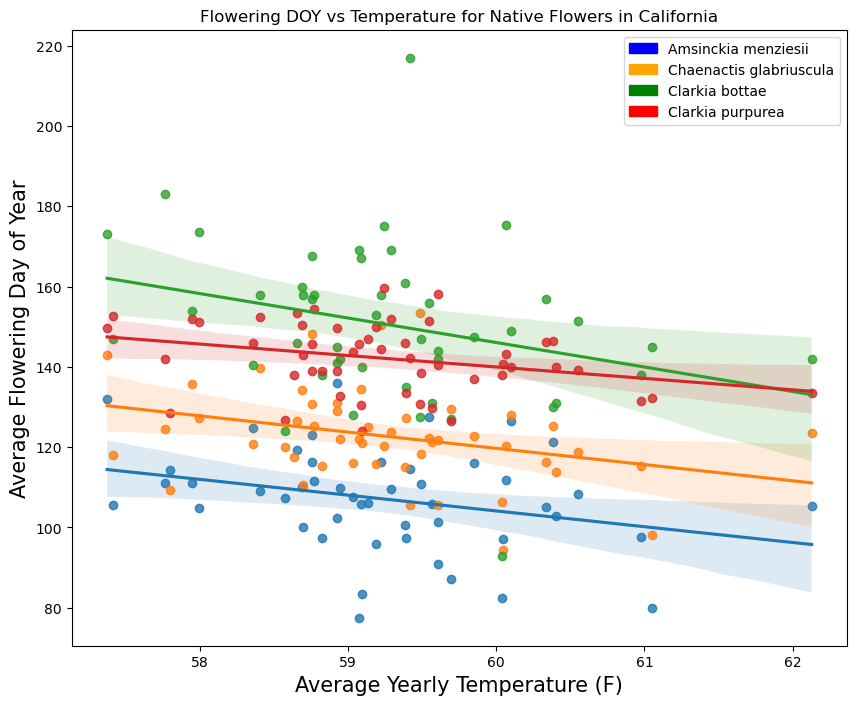

In [38]:
#| code-fold: true
#| code-summary: "Flowering DOY vs Temperature for Native Flowers in California"

# set plot size
g = plt.figure(figsize = [10,8])
# empty list to store legend
l = []
# create a list of colors for each species
c = ['blue', 'orange', 'green', 'red']

# iterate over the unique species and plot the linear regression for each species
for i in range(len(stateSig.Species.unique())):
    g = sb.regplot(data = stateSig[stateSig['Species'] == stateSig.Species.unique()[i]],
               x = 'ANN', y = 'DOY')
    red_patch = mpatches.Patch(color=c[i], label=f'{stateSig.Species.unique()[i]}')
    l.append(red_patch)
g.set_title("Flowering DOY vs Temperature for Native Flowers in California")
g.set_xlabel("Average Yearly Temperature (F)", fontsize = 15)
g.set_ylabel("Average Flowering Day of Year", fontsize = 15)
plt.legend(handles=l)
plt.savefig('stateSigT.png')

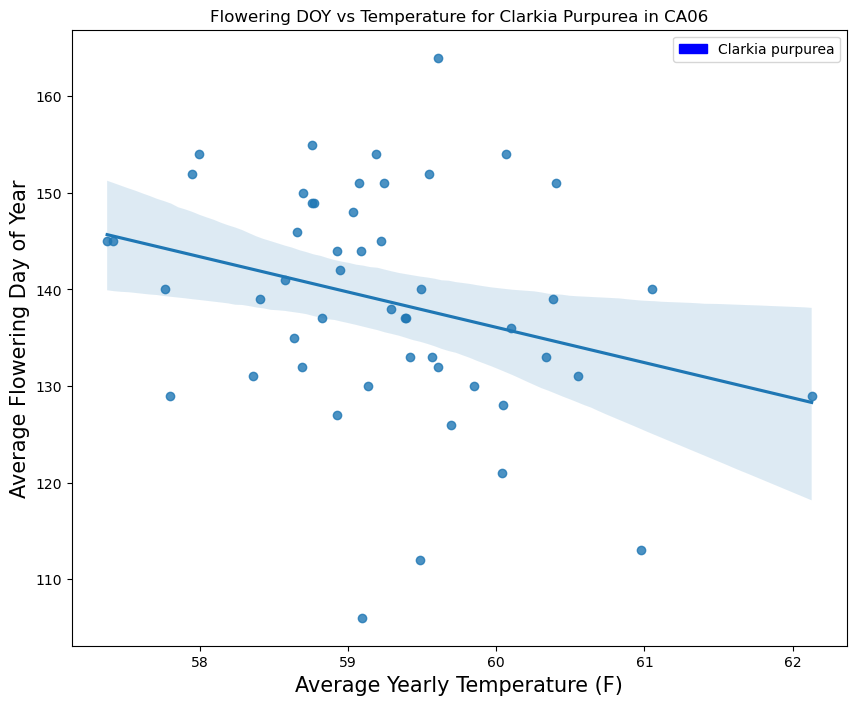

In [39]:
#| code-fold: true
#| code-summary: "Flowering DOY vs Temperature for Clarkia Purpurea in CA06"

# set plot size
h = plt.figure(figsize = [10,8])
# empty list to store legend 
l = []
# create a list of colors for each species
c = ['blue', 'orange', 'green', 'red']

# filter the significant summary data to temperature only
sixSigT = sixSig[sixSig['Type'] == 'T']

# iterate over the unique species and plot the linear regression for each species
for i in range(len(sixSigT.Species.unique())):
    h = sb.regplot(data = sixSigT[sixSigT['Species'] == sixSigT.Species.unique()[i]],
               x = 'ANN', y = 'DOY')
    red_patch = mpatches.Patch(color=c[i], label=f'{sixSigT.Species.unique()[i]}')
    l.append(red_patch)
h.set_title("Flowering DOY vs Temperature for Clarkia Purpurea in CA06")
h.set_xlabel("Average Yearly Temperature (F)", fontsize = 15)
h.set_ylabel("Average Flowering Day of Year", fontsize = 15)
plt.legend(handles=l)
plt.savefig('sixSigT.png')

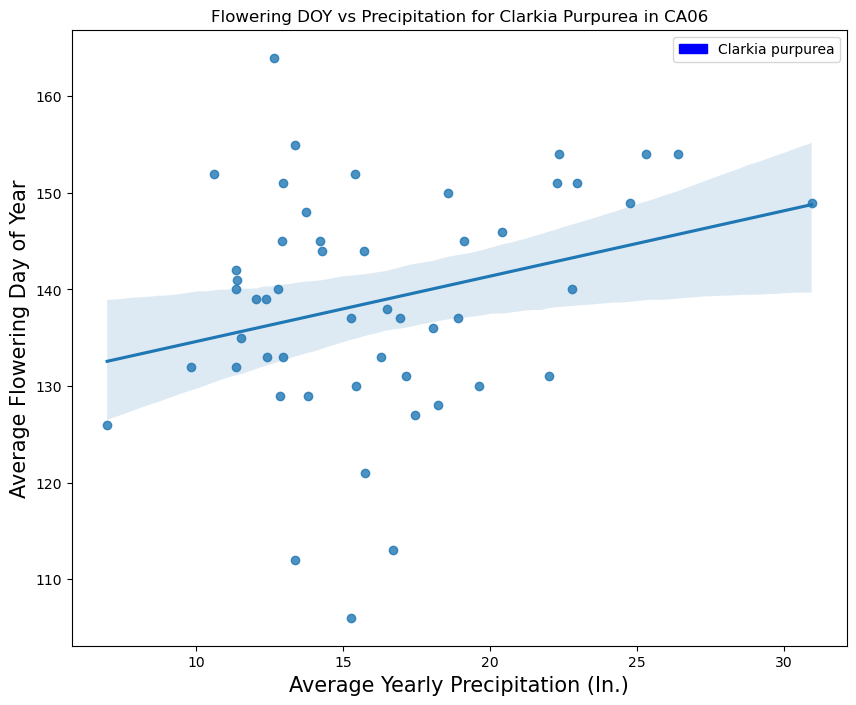

In [40]:
#| code-fold: true
#| code-summary: "Flowering DOY vs Precipitation for Clarkia Purpurea in CA06"

# set plot size
h = plt.figure(figsize = [10,8])
# empty list to store legend
l = []
# create a list of colors for each species
c = ['blue', 'orange', 'green', 'red']

# filter the significant summary data to precipitation only
sixSigP = sixSig[sixSig['Type'] == 'P']

# iterate over the unique species and plot the linear regression for each species
for i in range(len(sixSig.Species.unique())):
    h = sb.regplot(data = sixSigP[sixSigP['Species'] == sixSigP.Species.unique()[i]],
               x = 'ANN', y = 'DOY')
    red_patch = mpatches.Patch(color=c[i], label=f'{sixSigP.Species.unique()[i]}')
    l.append(red_patch)
h.set_title("Flowering DOY vs Precipitation for Clarkia Purpurea in CA06")
h.set_xlabel("Average Yearly Precipitation (In.)", fontsize = 15)
h.set_ylabel("Average Flowering Day of Year", fontsize = 15)
plt.legend(handles=l)
plt.savefig('sixSigP.png')

## Conclusion and Discussion 

This study addressed two key questions: (1) whether average flowering observation dates are influenced by temperature or precipitation changes, and (2) if specific climate zones, like coastal Southern California, exhibit more pronounced phenological shifts compared to statewide trends. 

**Key Findings:**
1. **Temperature and Phenology**: Across all species, significant correlations with temperature exhibited negative coefficients, indicating earlier flowering with rising temperatures. For instance, *Clarkia bottae* blooms ~11 days earlier for every 1°C temperature increase. Over 50 years, California's average temperature rose by ~1°C, significantly impacting native species.
   
2. **Precipitation and Phenology**: Significant correlations with precipitation were positive, meaning reduced rainfall led to earlier flowering. Though annual precipitation trends were not statistically significant, extreme events likely influence phenology and destabilize communities.

3. **Regional Patterns**: Statewide, only native species showed significant correlations with temperature. In coastal Southern California (climate division 6), significant responses were observed in *Clarkia purpurea* and *Chaenactis glabriuscula*, with *Clarkia purpurea* being sensitive to both temperature and precipitation.

4. **Native vs. Invasive Species**: Native species were more affected by climate change than invasive species, potentially giving invasives a competitive advantage. Earlier flowering in natives could lead to ecosystem shifts and competitive displacement by invasives.

**Limitations and Recommendations**:
- Limited species count and uneven data distribution across regions and species.
- Precipitation analysis could be refined by focusing on seasonal rather than annual totals.
- More comprehensive studies are needed, especially with equal representation of native and invasive species.

**Implications**:
Native species like *Clarkia purpurea*, critical to ecosystem stability, are highly vulnerable to climate change. Differential impacts across climate divisions necessitate tailored conservation strategies. Without intervention, these shifts could lead to ecosystem reorganization, favoring invasive species and jeopardizing native biodiversity.